In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import percentileofscore



import torch
from bayes_opt import BayesianOptimization

import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol


from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')

import zipfile
from io import BytesIO

import selfies as sf



c:\Users\lisa0\anaconda3\envs\LG_newmoses\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Try out with molecules

In [41]:
train_df = pd.read_csv("../gpr/optimize_gpr/gpr_fit_ZINC250K_df.csv")
test_df = pd.read_csv("../gpr/optimize_gpr/gpr_test_ZINC250K_df.csv")
start_df = pd.read_csv("../gpr/optimize_gpr/opt_start_ZINC250K_df.csv")


In [42]:
print(f'gpr train: {train_df.shape}')
print(f'gpr test: {test_df.shape}')
print(f'gpr start: {start_df.shape}')

gpr train: (10000, 6)
gpr test: (1000, 6)
gpr start: (100, 6)


In [68]:
model_name = 'VAEProp_obj_w0.1'
folder_path = "../checkpoints/ZINC250K_vae_property_obj_proploss_w0.1_SELF"
config = torch.load(f'{folder_path}/vae_property_config.pt')
vocab = torch.load(f'{folder_path}/vae_property_vocab.pt')

print(f"Use Selfies: {config.use_selfies}")

Use Selfies: True


In [69]:
config.reg_prop_tasks

['obj']

In [70]:
cols = ['SELFIES' if config.use_selfies else 'SMILES', 'logP', 'qed', 'SAS', 'obj']
train_data = train_df[cols].values
test_data = test_df[cols].values
start_data = start_df[cols].values


model_path = f'{folder_path}/vae_property_model_060.pt'


model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(model_path))

trainer = VAEPROPERTYTrainer(config)
train_loader = trainer.get_dataloader(model, train_data, shuffle=False)
test_loader = trainer.get_dataloader(model, test_data, shuffle=False)
start_loader = trainer.get_dataloader(model, start_data, shuffle=False)

In [71]:
train_data.shape

(10000, 5)

In [72]:
model.eval()

x_list = []
z_list = []
mu_list = []
logvar_list = []
y_list = []


# y_list = y_list.squeeze()

for step, batch in enumerate(train_loader):
    x = batch[0]
    y = batch[1]
    x_list.extend(x)
    y_list.extend(np.array(y).squeeze())

    mu, logvar, z, _ = model.forward_encoder(x)
    z_list.extend(z.detach().cpu().numpy())
    mu_list.extend(mu.detach().cpu().numpy())
    logvar_list.extend(logvar.detach().cpu().numpy())



y_list = np.array(y_list).squeeze()
GP_train_y = y_list.reshape(-1, y_list.shape[-1])

train_data_df = pd.DataFrame(GP_train_y, columns=['logP', 'qed', 'SAS', 'obj'])
train_data_df['z'] = z_list
train_data_df['mu'] = mu_list
train_data_df['logvar'] = logvar_list
train_data_df.insert(0, 'SELFIES' if config.use_selfies else 'SMILES', [vocab.ids2string(point.cpu().detach().numpy()) for point in x_list])

GP_train_y = GP_train_y[:, 3]

In [73]:
train_data_df.head()

,SELFIES,logP,qed,SAS,obj,z,mu,logvar
0,[C][C][C][=C][Branch1][C][N][C][=N][N][=C][Bra...,3.47076,0.606420,2.517309,0.514790,"[-0.5037479, 0.8436171, 0.7949637, -2.237842, ...","[-0.008027887, 0.03268415, 0.018490091, -0.023...","[-0.0015584719, -0.008516157, -0.009706736, 0...."
1,[C][C][=N][N][Branch1][C][C][C][=Branch1][C][=...,1.55844,0.899021,2.404992,2.090114,"[1.4466282, -0.5146939, 0.63040876, -0.5892980...","[-0.013777426, 0.005107562, 0.007383149, -0.02...","[0.0037225548, -0.004462365, -0.0051257536, -0..."
2,[C][C][=Branch1][C][=O][N][Branch1][C][C][C][C...,1.68640,0.762796,2.688692,1.125289,"[-0.23263727, -1.0472856, 2.554517, 0.7243474,...","[0.006029931, -0.006815072, 0.018088836, -0.00...","[0.00021491013, -0.0018001487, -0.0036796406, ..."
3,[O][=C][Branch2][Ring1][S][C][C][C][=Branch1][...,0.65710,0.806322,3.069383,0.962225,"[0.2548453, -0.88161916, 1.5690298, -1.37915, ...","[0.011431943, 0.015785733, 0.027089342, -0.008...","[0.0061513647, 0.00569857, -0.011935233, 0.003..."
4,[C][C][=C][C][=C][Branch2][Ring1][=N][N][C][C]...,1.77674,0.880351,2.452121,1.949633,"[-0.96659136, 0.6788206, -0.9933087, -0.050709...","[-0.0048026736, 0.02113053, 0.019844133, -0.01...","[0.0015051975, -0.0056968983, -0.011653493, -0..."


In [74]:
model.eval()

x_list = []
z_list = []
mu_list = []
logvar_list = []
y_list = []



# y_list = y_list.squeeze()

for step, batch in enumerate(start_loader):
    x = batch[0]
    y = batch[1]
    x_list.extend(x)
    y_list.extend(np.array(y).squeeze())

    mu, logvar, z, _ = model.forward_encoder(x)
    z_list.extend(z.detach().cpu().numpy())
    mu_list.extend(mu.detach().cpu().numpy())
    logvar_list.extend(logvar.detach().cpu().numpy())



rest_z = np.array(z_list).squeeze()
y_list = np.array(y_list).squeeze()
rest_y = y_list.reshape(-1, y_list.shape[-1])

start_data_df = pd.DataFrame(rest_y, columns=['logP', 'qed', 'SAS', 'obj'])
start_data_df['z'] = z_list
start_data_df['mu'] = mu_list
start_data_df['logvar'] = logvar_list
start_data_df.insert(0, 'SELFIES' if config.use_selfies else 'SMILES', [vocab.ids2string(point.detach().cpu().numpy()) for point in x_list])

rest_y = rest_y[:, 3]

In [75]:
start_data_df.head()

,SELFIES,logP,qed,SAS,obj,z,mu,logvar
0,[O][=C][Branch2][Ring1][Branch2][C][=C][C][=C]...,3.21630,0.774991,2.504857,1.370096,"[-0.31623867, 2.7089593, -1.1322674, -0.137438...","[-0.013374955, 0.024883281, 0.00860896, -0.012...","[0.008404691, -0.00040152017, -0.006946001, 0...."
1,[C][C][=C][C][=C][O][C][Branch2][Ring1][#Branc...,3.46386,0.717621,3.021269,0.566838,"[-0.8385483, 1.6735791, 0.8929297, -0.3347804,...","[-0.008670532, 0.018704847, 0.00920384, -0.011...","[0.0007933532, -0.006339319, -0.005084444, 0.0..."
2,[C][C][=C][C][=C][N][C][=Branch1][C][=O][C][C]...,1.36850,0.659434,3.079656,0.217511,"[-0.78981507, -0.4553683, -0.7475521, 0.267846...","[-0.0066360054, 0.008164436, 0.019597527, -0.0...","[0.0024051731, -0.008243971, -0.0037671942, 0...."
3,[N][S][=Branch1][C][=O][=Branch1][C][=O][C][=C...,0.22470,0.710384,2.239069,1.312852,"[-0.3509081, 1.4582522, 0.86562735, -1.1291665...","[-0.0054521137, -0.0020879523, -0.0037036613, ...","[0.0018384368, -0.008291362, -0.005270539, -0...."
4,[C][N][C][=Branch1][C][=O][C][Branch1][C][C][C...,0.49040,0.872901,3.121113,1.243390,"[-0.6769191, -0.08929653, -1.3480343, -1.99420...","[-0.0058272863, -0.00058084074, 0.00588252, -0...","[0.0019207555, -0.0041709375, -0.0013358817, 0..."


In [76]:
start_data_df.shape, train_data_df.shape


((100, 8), (10000, 8))

In [77]:
mu_argmax, y_bef_mu = model.sample(n_batch=len(train_data_df), z=torch.tensor(train_data_df['mu']).float(), test=True)
z_argmax, y_bef_z = model.sample(n_batch=len(train_data_df), z=torch.tensor(train_data_df['z']).float(), test=True)


In [78]:
vocab.c2i

{'#Branch1': 0,
 '#Branch2': 1,
 '#C': 2,
 '#N': 3,
 '=Branch1': 4,
 '=Branch2': 5,
 '=C': 6,
 '=N': 7,
 '=O': 8,
 '=Ring1': 9,
 '=Ring2': 10,
 '=S': 11,
 'Br': 12,
 'Branch1': 13,
 'Branch2': 14,
 'C': 15,
 'Cl': 16,
 'F': 17,
 'H': 18,
 'N': 19,
 'NH1': 20,
 'O': 21,
 'P': 22,
 'Ring1': 23,
 'Ring2': 24,
 'S': 25,
 '<bos>': 26,
 '<eos>': 27,
 '<pad>': 28,
 '<unk>': 29}

In [79]:
y_bef_mu[0][0]

tensor([-13.1515,  -0.0248,   1.9511,  -2.4462, -13.8567,  -5.0030,  -6.4386,
        -10.5211,  -8.9260, -13.8391, -14.3004,  -6.6900,   1.2219,  -6.1399,
         -4.0193,  17.3183,   5.5821,   8.7329,   1.3463,  10.7332,  -4.5713,
         11.3603,  -3.6723, -11.9227,  -7.3847,  -1.1303,  -9.5180,  -1.1618,
         -9.7145,  -9.2315])

In [65]:
y_bef_mu
w = torch.argmax(y_bef_mu[0], dim=-1)
w

tensor([12, 12, 12,  ..., 12, 16, 12])

In [80]:
train_data_df['mu_argmax'] = mu_argmax
train_data_df['z_argmax'] = z_argmax

In [83]:
len(train_data_df)

10000

In [82]:
len(train_data_df['z_argmax'].unique())

1789

In [30]:
train_mu = np.vstack(train_data_df['mu'].values)
train_logvar = np.vstack(train_data_df['logvar'].values)

n_sample = 100

#train_mu = train_data_df['mu'].values
#train_logvar = train_data_df['logvar'].values

#train_mu = np.array([mu for mu in train_mu])
#train_logvar = np.array([logvar for logvar in train_logvar])

GP_train_X = np.array([mu + np.exp(logvar / 2) * np.random.randn(n_sample, mu.shape[-1]) for mu, logvar in zip(train_mu, train_logvar)])
GP_train_X = GP_train_X.reshape(-1, GP_train_X.shape[-1])
print(GP_train_X.shape)
GP_train_y = np.array([y for y in GP_train_y for _ in range(n_sample)])

(20000, 128)


In [31]:
clf = GaussianProcessRegressor(random_state=42)
clf.fit(GP_train_X, GP_train_y)

In [17]:
start_mu = np.vstack(start_data_df['mu'].values)
start_logvar = np.vstack(start_data_df['logvar'].values)
print(start_mu.shape)
rest_X = np.array([mu + np.exp(logvar / 2) * np.random.randn(1, mu.shape[-1]) for mu, logvar in zip(start_mu, start_logvar)])
rest_X = rest_X.reshape(-1, rest_X.shape[-1])

print(rest_X.shape)

print(f"R2 Score: {clf.score(rest_X, rest_y)}")
#print(f"R2 Score: {clf.score(GP_train_X, GP_train_y)}")

(100, 128)
(100, 128)
R2 Score: -12.022489932252814


In [14]:
def f(x, gaussian):
    pred_mean = gaussian.predict(x)[0]

    return pred_mean

In [15]:
optimal_z_list = []

# Adam Gradient Ascent 수행
for z in tqdm(rest_z):
    initial_point = np.array(z)
    optimal_z = adam_gradient_ascent(f, clf, initial_point)
    optimal_z_list.append(optimal_z)

100%|██████████| 100/100 [1:53:41<00:00, 68.22s/it]


In [16]:
np.array(optimal_z_list).shape

(100, 128)

In [17]:
optimal_z_list = torch.tensor(optimal_z_list).float()

In [18]:
torch.save(optimal_z_list, f'../checkpoints/optimize_gpr/{model_name}_optimal_z.pt')

In [91]:
# save optimal_z_list
#torch.save(optimal_z_list, f'../checkpoints/optimize_gpr/optimal_z_list.pt')
# optimal_z_list = torch.load('../checkpoints/optimize_gpr/optimal_z_list.pt')

In [19]:
gen_argmax = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, test=True)
gen_temp_1 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=1)
gen_temp_point5 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.5)
gen_temp_point7 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.7)

In [20]:
gen_temp_point01 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.01)
gne_temp_point1 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.1)
gen_temp_point3 = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=0.3)

In [21]:
def create_opt_df(gen_molecule, config, type='opt', start_df=start_df):
    if config.use_selfies:
        opt_df = pd.DataFrame(gen_molecule, columns=['gen_SELFIES'])
        opt_df['gen_SMILES'] = [sf.decoder(s) for s in opt_df['gen_SELFIES']]
    else:
        opt_df = pd.DataFrame(gen_molecule, columns=['gen_SMILES'])
    opt_df['gen_romol'] = [get_mol(mol) for mol in opt_df['gen_SMILES']]
    opt_df = opt_df.dropna(subset=['gen_romol'])

    opt_df['gen_logP'] = [logP(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_qed'] = [QED(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_SAS'] = [SA(mol) for mol in opt_df['gen_romol']]
    opt_df['gen_obj'] = 5*opt_df['gen_qed'] - opt_df['gen_SAS']

    opt_set = set(opt_df["gen_SELFIES" if config.use_selfies else "gen_SMILES"].values)
    print(f'----{type}----')
    print(f'valid: {len(opt_df)}/{len(start_df)}')
    print(f'unique: {len(opt_set)}/{len(opt_df)}')




    return opt_df

In [22]:
# ignore the error of rdkit
from rdkit import rdBase
#from rdkit import RDLogger

rdBase.DisableLog('rdApp.*')
#rdBase.EnableLog('rdApp.*') 

In [23]:
zinc_df = pd.read_csv('../moses/dataset/data/ZINC250K/train.csv')
#test_df = pd.read_csv('../moses/dataset/data/ZINC250K/test.csv')
# concat zinc_df with test_df
#zinc_df = pd.concat([zinc_df, test_df], axis=0)
zinc_df.shape

(250000, 6)

In [24]:
def plot_violins(temps):
    plt.figure(figsize=(12, 6))
    for idx, temp in enumerate(temps):
        temp = round(temp, 2)
        gen = model.sample(n_batch=len(optimal_z_list), z=optimal_z_list, temp=temp)
        gen_df = create_opt_df(gen, config, type=f'temp {temp}')
        pct_df = pd.DataFrame({'obj_pct': [percentileofscore(zinc_df['obj'], obj) for obj in set(gen_df['gen_obj'])]})

        sns.violinplot(x=idx, y='obj_pct', data=pct_df)

    plt.xticks([idx for idx in range(len(temps))], [round(temp,2) for temp in temps])
    plt.ylabel('objective percentile')

    plt.show()
    return plt




----temp 0.01----
valid: 100/100
unique: 15/100
----temp 0.02----
valid: 100/100
unique: 18/100
----temp 0.03----
valid: 100/100
unique: 24/100
----temp 0.04----
valid: 100/100
unique: 31/100
----temp 0.05----
valid: 100/100
unique: 37/100
----temp 0.06----
valid: 100/100
unique: 46/100
----temp 0.07----
valid: 100/100
unique: 45/100
----temp 0.08----
valid: 100/100
unique: 48/100
----temp 0.09----
valid: 100/100
unique: 47/100
----temp 0.1----
valid: 100/100
unique: 57/100


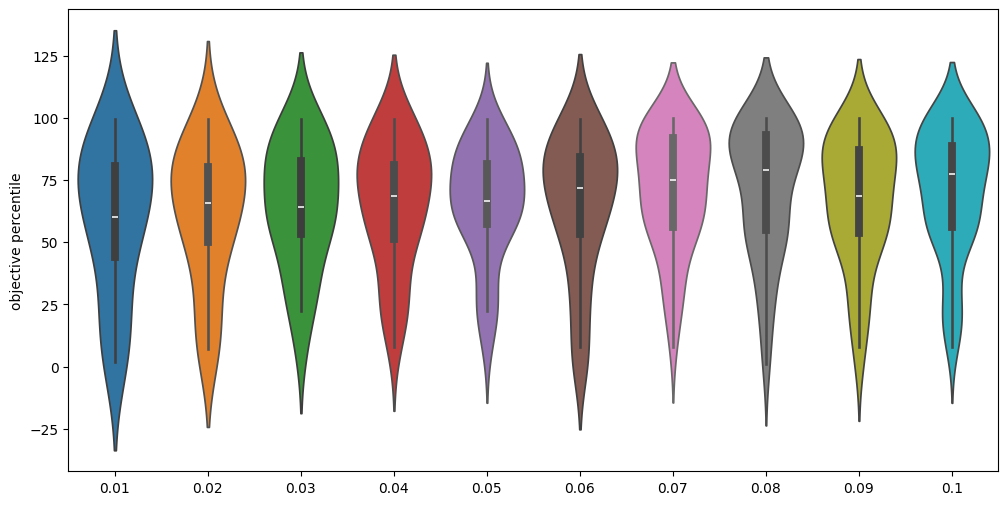

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [25]:
temps = np.linspace(0.01, 0.1, 10)
plot_violins(temps)

----temp 0.1----
valid: 100/100
unique: 59/100
----temp 0.2----
valid: 100/100
unique: 93/100
----temp 0.3----
valid: 100/100
unique: 97/100
----temp 0.4----
valid: 100/100
unique: 99/100
----temp 0.5----
valid: 100/100
unique: 100/100
----temp 0.6----
valid: 100/100
unique: 100/100
----temp 0.7----
valid: 100/100
unique: 100/100
----temp 0.8----
valid: 100/100
unique: 100/100
----temp 0.9----
valid: 100/100
unique: 100/100
----temp 1.0----
valid: 100/100
unique: 100/100


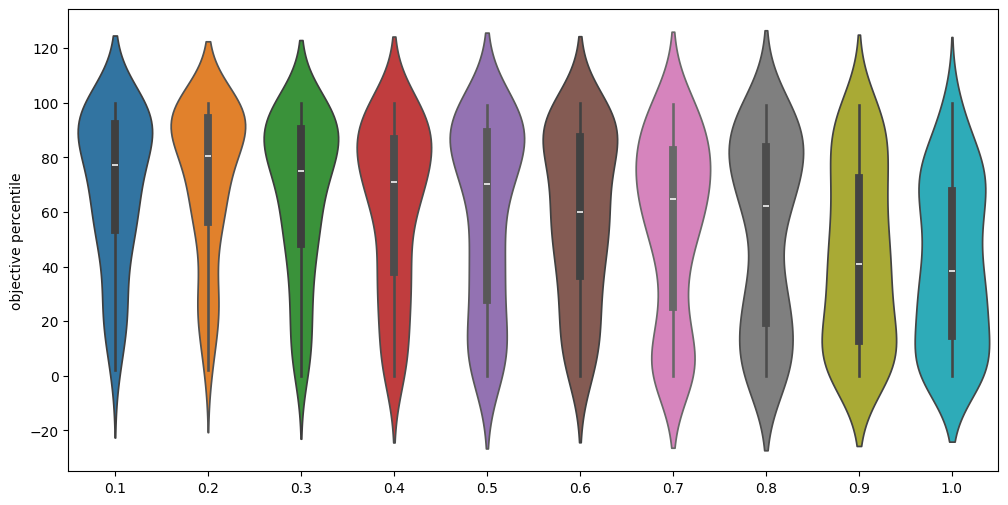

<module 'matplotlib.pyplot' from 'c:\\Users\\lisa0\\anaconda3\\envs\\LG_newmoses\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [26]:
temps = np.linspace(0.1, 1, 10)
plot_violins(temps)

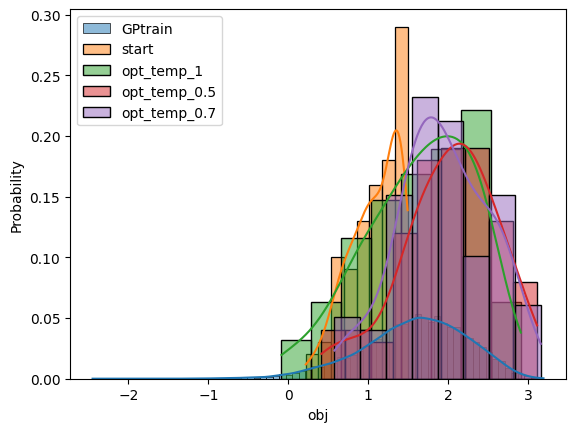

In [109]:
sns.histplot(train_data_df['obj'], kde=True, label='GPtrain', stat='probability')
sns.histplot(start_data_df['obj'], kde=True, label='start', stat='probability')
#sns.histplot(opt_argmax_df['gen_obj'], kde=True, label='opt_arg', stat='probability')
sns.histplot(opt_temp_1_df['gen_obj'], kde=True, label='opt_temp_1', stat='probability')
sns.histplot(opt_temp_point5_df['gen_obj'], kde=True, label='opt_temp_0.5', stat='probability')
sns.histplot(opt_temp_point7_df['gen_obj'], kde=True, label='opt_temp_0.7', stat='probability')
plt.legend()
plt.show()

In [111]:
train_df.shape

(10000, 6)

In [160]:
pct_df = pd.DataFrame({'obj_pct': [percentileofscore(train_df['obj'], obj) for obj in set(opt_argmax_df['gen_obj'])]})
pct_df


,obj_pct
0,53.23


[22:22:34] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 23
[22:22:34] SMILES Parse Error: unclosed ring for input: 'Cc1cnc(N2CC3CC(C(=O)Nc4ccccc4)C(C(C)C)C3O)nc1=O'
[22:22:34] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 7 22 23
c:\Users\lisa0\anaconda3\envs\LG_newmoses\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


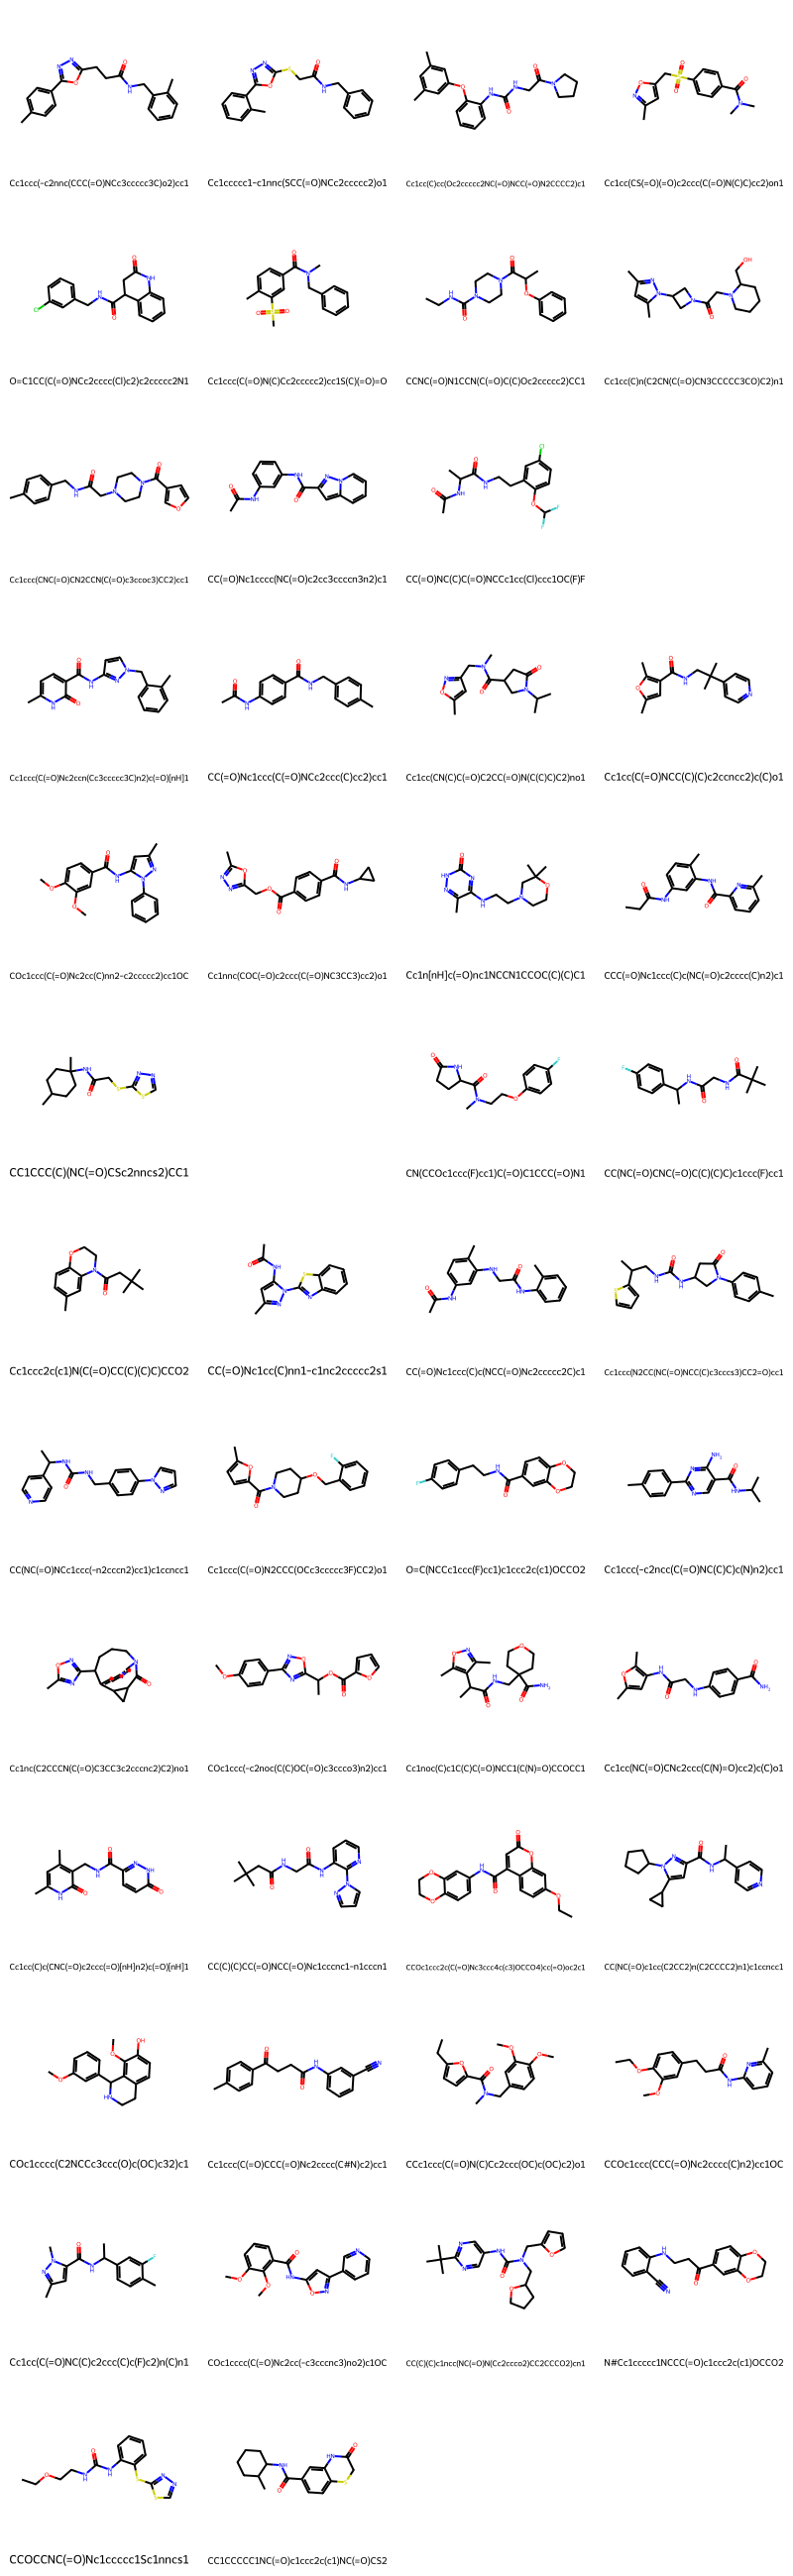

In [ ]:
if config.use_selfies:
    
    viz_df = pd.DataFrame({"SELFIES": gen_molecule_argmax})

    smiles = []
    for selfies in viz_df['SELFIES']:
        smiles.append(sf.decoder(selfies))

    viz_df['RoMol'] = smiles
    viz_df['RoMol'] = viz_df['RoMol'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(viz_df, column='RoMol', legendsCol='SELFIES', molsPerRow=4))
else:
    viz_df = pd.DataFrame({"SMILES": gen_molecule})
    viz_df['RoMol'] = viz_df['SMILES'].apply(Chem.MolFromSmiles)
    display(PandasTools.FrameToGridImage(viz_df, column='RoMol', legendsCol='SMILES', molsPerRow=4))